<a href="https://colab.research.google.com/github/haoheliu/Channel-wise-Subband-Input/blob/master/subband.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo of Subband Operations
This is a demo for Subband decomposition(analysis) and reconstruction(synthesis), in both time domain and frequency domain. Let's first take a glance at the function we need.

# Time domain subband analysis
```python
class PQMF:
  analysis(inputs) # [batchsize,channel,raw_wav] -> [batchsize, channel*SUBBAND_NUM,raw_wav]
  synthesis(data) # [batchsize,channel*SUBBAND_NUM,raw_wav] -> [batchsize,channel,raw_wav]
```
After analysis, the sample rate of original signal reduce SUBBAND_NUM fold.
Before you use this two function, you need to initialize a PQMF object like this:
```python
qmf_4 = PQMF(4,64,filters_dir = "./filters") # SUBBAND_NUM=4
# or
qmf_4 = PQMF(2,64,filters_dir = "./filters") # SUBBAND_NUM=2
# or
qmf_4 = PQMF(8,64,filters_dir = "./filters") # SUBBAND_NUM=8
```
We have pre-define some filters [here](https://github.com/haoheliu/Subband-Music-Separation/tree/master/util/subband/filters). If you wanna run this script, you need to download them and upload them to colab, then specify the path to the filter when initilize PQMF. (The details for the use of pre-defined filters can be found in the next section)

# Frequency domain subband analysis

In the previous section, we get the time domain subband signal. But usually we like to work on frequency domain. So I wrote two wrapper functions for you. They can help you transfer each subband signal into frequency domain and reconstruct them back painlessly after whatever you wanna do to the subband signal. 

```python
# Two inter-reversable functions
before_forward() # [batchsize,channels,wave] -> [batchsize,SUBBAND_NUM*2*2,frequency_bin,time_step]
after_forward() # [batchsize,SUBBAND_NUM*2*2,frequency_bin,time_step] -> [batchsize,channels,wave]
```

Here the channel number is SUBBAND_NUM\*2\*2. The first '2' represent two channels. And the second '2' represent real and imagery part after STFT.  

So let's go on and see how it works. 

Something worth mention: 
1. **But before that, you need to download our pre-defined analysis and synthesis filters** [here](https://github.com/haoheliu/Subband-Music-Separation/tree/master/util/subband/filters). Make a new directory "filters" on colab and put them in. You will need to specify this dir to PQMF object when initilizing it.

2. You also need to [**download a song**](https://github.com/haoheliu/Subband-Music-Separation/blob/master/additional_data/song.wav) to colab for the program to use. After that, your directory on colab will look like:

  <!-- - filters/
    - f_2_64.mat
    - f_4_64.mat
    - f_8_64.mat
    - h_2_64.mat
    - h_4_64.mat
    - h_8_64.mat
  - song.wav -->

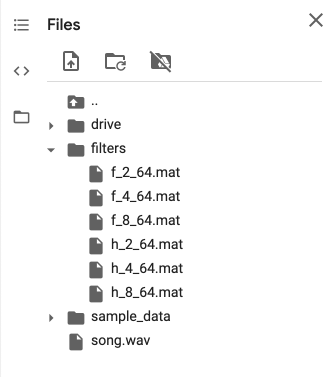
3. The first cell is some support code. You need to **run them first**.


In [55]:
# ATTENTION!!!!    Please run this block first. Then goto next cell.

import torch
import torch.nn as nn
import numpy as np
import os.path as op
from scipy.io import loadmat
import math
import wave

def get_window(window_size, window_type, square_root_window=True):
    """Return the window"""
    window = {
        'hamming': torch.hamming_window(window_size),
        'hanning': torch.hann_window(window_size),
    }[window_type]
    if square_root_window:
        window = torch.sqrt(window)
    return window


def fft_point(dim):
    assert dim > 0
    num = math.log(dim, 2)
    num_point = 2**(math.ceil(num))
    return num_point


def pre_emphasis(signal, coefficient=0.97):
    """Pre-emphasis original signal
    y(n) = x(n) - a*x(n-1)
    """
    return np.append(signal[0], signal[1:] - coefficient * signal[:-1])


def de_emphasis(signal, coefficient=0.97):
    """De-emphasis original signal
    y(n) = x(n) + a*x(n-1)
    """
    length = signal.shape[0]
    for i in range(1, length):
        signal[i] = signal[i] + coefficient * signal[i - 1]
    return signal

def seperate_magnitude(magnitude,phase):
    real = torch.cos(phase) * magnitude
    imagine = torch.sin(phase) * magnitude
    expand_dim = len(list(real.size()))
    return torch.stack((real,imagine),expand_dim)

def stft(signal,
         sample_rate,
         frame_length=32,
         frame_shift=8,
         window_type="hanning",
         device = torch.device("cpu"),
         square_root_window=True):
    """Compute the Short Time Fourier Transform.

    Args:
        signal: input speech signal叠
        sample_rate: waveform data sample frequency (Hz)
        frame_length: frame length in milliseconds
        frame_shift: frame shift in milliseconds
        window_type: type of window
        square_root_window: square root window
    Return:
        fft: (n/2)+1 dim complex STFT restults
    """
    hop_length = int(sample_rate * frame_shift / 1000) # The greater sample_rate, the greater hop_length
    win_length = int(sample_rate * frame_length / 1000)
    num_point = fft_point(win_length)
    window = get_window(num_point, window_type, square_root_window)
    if('cuda' in str(device)):
        window = window.cuda(device)
    feat = torch.stft(signal, n_fft=num_point, hop_length=hop_length,
                        win_length=window.shape[0], window=window)
    return feat


# def get_phase(signal,
#               sample_rate,
#               frame_length=32,
#               frame_shift=8,
#               window_type="hanning",
#               preemphasis=0.0,
#               square_root_window=True):
#     """Compute phase imformation.
#
#     Args:
#         signal: input speech signal
#         sample_rate: waveform data sample frequency (Hz)
#         frame_length: frame length in milliseconds
#         frame_shift: frame shift in milliseconds
#         window_type: type of window
#         square_root_window: square root window
#     """
#     feat = stft(signal, sample_rate, frame_length, frame_shift,
#                 window_type, preemphasis, square_root_window)
#     phase = np.angle(feat)
#     return phase


def istft(spectrum,
                    sample_rate,
                    frame_length=32,
                    frame_shift=8,
                    window_type="hanning",
                    preemphasis=0.0,
                    device = torch.device('cpu'),
                    square_root_window=True):
    """Convert frames to signal using overlap-and-add systhesis.
    Args:
        spectrum: magnitude spectrum [batchsize,x,y,2]
        signal: wave signal to supply phase information
    Return:
        wav: synthesied output waveform
    """
    hop_length = int(sample_rate * frame_shift / 1000)
    win_length = int(sample_rate * frame_length / 1000)

    num_point = fft_point(win_length)
    if('cuda' in str(device)):
        window = get_window(num_point, window_type, square_root_window).cuda(device)
    else:
        window = get_window(num_point, window_type, square_root_window)

    wav = torch_istft(spectrum, num_point,hop_length=hop_length,
                        win_length=window.shape[0], window=window)
    return wav

def torch_istft(stft_matrix,          # type: Tensor
          n_fft,                # type: int
          hop_length=None,      # type: Optional[int]
          win_length=None,      # type: Optional[int]
          window=None,          # type: Optional[Tensor]
          center=True,          # type: bool
          pad_mode='reflect',   # type: str
          normalized=False,     # type: bool
          onesided=True,        # type: bool
          length=None           # type: Optional[int]
          ):
    # type: (...) -> Tensor

    stft_matrix_dim = stft_matrix.dim()
    assert 3 <= stft_matrix_dim <= 4, ('Incorrect stft dimension: %d' % (stft_matrix_dim))

    if stft_matrix_dim == 3:
        # add a channel dimension
        stft_matrix = stft_matrix.unsqueeze(0)

    dtype = stft_matrix.dtype
    device = stft_matrix.device
    fft_size = stft_matrix.size(1)
    assert (onesided and n_fft // 2 + 1 == fft_size) or (not onesided and n_fft == fft_size), (
        'one_sided implies that n_fft // 2 + 1 == fft_size and not one_sided implies n_fft == fft_size. ' +
        'Given values were onesided: %s, n_fft: %d, fft_size: %d' % ('True' if onesided else False, n_fft, fft_size))

    # use stft defaults for Optionals
    if win_length is None:
        win_length = n_fft

    if hop_length is None:
        hop_length = int(win_length // 4)

    # There must be overlap
    assert 0 < hop_length <= win_length
    assert 0 < win_length <= n_fft

    if window is None:
        window = torch.ones(win_length, requires_grad=False, device=device, dtype=dtype)

    assert window.dim() == 1 and window.size(0) == win_length

    if win_length != n_fft:
        # center window with pad left and right zeros
        left = (n_fft - win_length) // 2
        window = torch.nn.functional.pad(window, (left, n_fft - win_length - left))
        assert window.size(0) == n_fft
    # win_length and n_fft are synonymous from here on

    stft_matrix = stft_matrix.transpose(1, 2)  # size (channel, n_frames, fft_size, 2)
    stft_matrix = torch.irfft(stft_matrix, 1, normalized,
                              onesided, signal_sizes=(n_fft,))  # size (channel, n_frames, n_fft)

    assert stft_matrix.size(2) == n_fft
    n_frames = stft_matrix.size(1)

    ytmp = stft_matrix * window.view(1, 1, n_fft)  # size (channel, n_frames, n_fft)
    # each column of a channel is a frame which needs to be overlap added at the right place
    ytmp = ytmp.transpose(1, 2)  # size (channel, n_fft, n_frames)

    eye = torch.eye(n_fft, requires_grad=False,
                    device=device, dtype=dtype).unsqueeze(1)  # size (n_fft, 1, n_fft)

    # this does overlap add where the frames of ytmp are added such that the i'th frame of
    # ytmp is added starting at i*hop_length in the output
    y = torch.nn.functional.conv_transpose1d(
        ytmp, eye, stride=hop_length, padding=0)  # size (channel, 1, expected_signal_len)

    # do the same for the window function
    window_sq = window.pow(2).view(n_fft, 1).repeat((1, n_frames)).unsqueeze(0)  # size (1, n_fft, n_frames)
    window_envelop = torch.nn.functional.conv_transpose1d(
        window_sq, eye, stride=hop_length, padding=0)  # size (1, 1, expected_signal_len)

    expected_signal_len = n_fft + hop_length * (n_frames - 1)
    assert y.size(2) == expected_signal_len
    assert window_envelop.size(2) == expected_signal_len

    half_n_fft = n_fft // 2
    # we need to trim the front padding away if center
    start = half_n_fft if center else 0
    end = -half_n_fft if length is None else start + length

    y = y[:, :, start:end]
    window_envelop = window_envelop[:, :, start:end]

    # check NOLA non-zero overlap condition
    window_envelop_lowest = window_envelop.abs().min()
    assert window_envelop_lowest > 1e-11, ('window overlap add min: %f' % (window_envelop_lowest))

    y = (y / window_envelop).squeeze(1)  # size (channel, expected_signal_len)

    if stft_matrix_dim == 3:  # remove the channel dimension
        y = y.squeeze(0)
    return y

def load_mat2numpy(fname=""):
    '''
    Args:
        fname: pth to mat
        type:
    Returns: dic object
    '''
    if (len(fname) == 0):
        return None
    else:
        return loadmat(fname)


class PQMF(nn.Module):
    def __init__(self, N, M, filters_dir):
        super().__init__()
        self.N = N  # nsubband
        self.M = M  # nfilter
        try:
            assert (N, M) in [(8, 64), (4, 64), (2, 64)]
        except:
            print("Warning:", N, "subbandand ", M, " filter is not supported")

        self.name = str(N) + "_" + str(M) + ".mat"
        self.ana_conv_filter = nn.Conv1d(1, out_channels=N, kernel_size=M, stride=N, bias=False)
        data = load_mat2numpy(op.join(filters_dir,"f_" + self.name))
        data = data['f'].astype(np.float32) / N
        data = np.flipud(data.T).T
        data = np.reshape(data, (N, 1, M)).copy()
        dict_new = self.ana_conv_filter.state_dict().copy()
        dict_new['weight'] = torch.from_numpy(data)
        self.ana_pad = nn.ConstantPad1d((M - N, 0), 0)
        self.ana_conv_filter.load_state_dict(dict_new)

        self.syn_pad = nn.ConstantPad1d((0, M // N - 1), 0)
        self.syn_conv_filter = nn.Conv1d(N, out_channels=N, kernel_size=M // N, stride=1, bias=False)
        gk = load_mat2numpy(op.join(filters_dir,"h_" + self.name))
        gk = gk['h'].astype(np.float32)
        gk = np.transpose(np.reshape(gk, (N, M // N, N)), (1, 0, 2)) * N
        gk = np.transpose(gk[::-1, :, :], (2, 1, 0)).copy()
        dict_new = self.syn_conv_filter.state_dict().copy()
        dict_new['weight'] = torch.from_numpy(gk)
        self.syn_conv_filter.load_state_dict(dict_new)

        for param in self.parameters():
            param.requires_grad = False

    def __analysis_channel(self, inputs):
        return self.ana_conv_filter(self.ana_pad(inputs))

    def __systhesis_channel(self, inputs):
        ret = self.syn_conv_filter(self.syn_pad(inputs)).permute(0, 2, 1)
        return torch.reshape(ret, (ret.shape[0], 1, -1))

    def analysis(self, inputs):
        '''
        :param inputs: [batchsize,channel,raw_wav]
        :return:
        '''
        ret = None
        for i in range(inputs.size()[1]):  # channels
            if (ret is None):
                ret = self.__analysis_channel(inputs[:, i:i + 1, :])
            else:
                ret = torch.cat((ret,
                                 self.__analysis_channel(inputs[:, i:i + 1, :]))
                                , dim=1)
        return ret

    def synthesis(self, data):
        '''
        :param data: [batchsize,self.N*K,raw_wav_sub]
        :return:
        '''
        ret = None
        for i in range(data.size()[1]):  # channels
            if (i % self.N == 0):
                if (ret is None):
                    ret = self.__systhesis_channel(data[:, i:i + self.N, :])
                else:
                    new = self.__systhesis_channel(data[:, i:i + self.N, :])
                    ret = torch.cat((ret, new), dim=1)
        return ret

    def forward(self, inputs):
        return self.ana_conv_filter(self.ana_pad(inputs))

def read_wave(fname,
                  convert_to_mono = False,
                  portion_start = 0,
                  portion_end = 1,
                  ): # Whether you want raw bytes
        if(portion_end > 1 and portion_end < 1.1):
            portion_end = 1
        f = wave.open(fname)
        params = f.getparams()
        channel = params[0]
        if(portion_end <= 1):
            raw = f.readframes(params[3])
            frames = np.fromstring(raw, dtype=np.short)
            if(frames.shape[0] % 2 == 1):frames = np.append(frames,0)
            frames.shape = -1, channel
            start, end = int(frames.shape[0] * portion_start), int(frames.shape[0] * portion_end)
            # Convert to mono
            if(convert_to_mono):frames = frames[start:end+1, 0]
            else:frames = frames[start:end+1, :]
        else:
            f.setpos(portion_start)
            raw = f.readframes(portion_end-portion_start)
            frames = np.fromstring(raw, dtype=np.short)
            if (frames.shape[0] % 2 == 1): frames = np.append(frames, 0)
            frames.shape = -1, channel
            if(convert_to_mono):frames = frames[:,0]
            else:frames = frames[:,:]
        return frames


def before_forward(
        *args,
        qmf = PQMF(4,64,"./filters"),
        device = torch.device("cpu"),
        subband_num=4,
        sample_rate=44100,
        normalize = True
):
    '''
    time domain -> freq domain & subband decomposition;
    This function can only be used in frequency domain;
    Args:
        *args: multiple raw wave inputs, format: [batchsize,channels,wave],value:[-32767,32767]
        device: torch.device
        subband_num: int, subband number to split:[2,4,8]
        sample_rate: int, default 44100
        normalize: if true the value of the output will be normalized to [-1,1]

    Returns:
        For each raw wave inputs, return a list with the same order as inputs
    '''
    def merge_channel(data):
        res = None
        for i in range(data.size(1)):
            if (res is None):
                res = data[:, i, ...]
            else:
                res = torch.cat((res, data[:, i, ...]), dim=-1)
        return res
    res = []
    for each in args: # for each keywords
        batchsize = each.size()[0]
        if(normalize):wave = each / 32768.0
        else:wave = each
        if (subband_num!=1):
            # wave = wave.unsqueeze(1) # torch.Size([3, 1, 22050])
            subband = qmf.analysis(wave) # torch.Size([3, 4, 5512])
            f_subband = None
            for i in range(batchsize): # for each subband
                # torch.Size([4, 513, 20, 2])
                item_f_subband = stft(subband[i,:,:],sample_rate=sample_rate/subband_num,device=device)
                item_f_subband = item_f_subband.permute(0,3,1,2)
                size = item_f_subband.size()
                item_f_subband = item_f_subband.reshape(-1,size[2],size[3]).unsqueeze(0)
                if(f_subband is None):
                    f_subband = item_f_subband # add a dimension for batch
                else:
                    f_subband = torch.cat((f_subband,item_f_subband),dim=0)

            res.append(f_subband)
        else:
            f_subband = None
            for i in range(batchsize):
                if(f_subband is None):
                    f_subband = stft(wave[i], sample_rate=sample_rate, device=device).unsqueeze(0)
                    f_subband = merge_channel(f_subband)
                else:
                    new = stft(wave[i], sample_rate=sample_rate, device=device).unsqueeze(0)
                    new = merge_channel(new)
                    f_subband = torch.cat((f_subband,new),dim=0)
            res.append(f_subband.permute(0,3,1,2))
    if(len(res) == 1):
        return res[0]
    else:
        return res


def after_forward(
        *args,
        qmf = PQMF(4,64,"./filters"),
        device = torch.device("cpu"),
        subband_num=4,
        sample_rate=44100,
        normalized = True
):
    '''
        freq domain -> time domain & subband synthesis;
        This function can only be used in frequency domain
        Args:
            *args: Arbitrary number of input, format:
                if(subband):[batchsize,subband_num*2*2,frequency_bin,time_step]
                if(not subband):[batchsize,4,frequency_bin,time_step]
            device: torch.device
            subband_num: int, subband number to split:[2,4,8]
            sample_rate: int, default 44100
            normalize: if true the value of the output will be normalized to [-1,1]

        Returns:
            A list of reconstructed raw waves
        '''
    def split_channels(data):
        data = data.permute(0,2,3,1)
        res = None
        for i in range(data.size()[-1]):
            if(i%2 == 0):
                if(res is None):
                    res = data[...,i:i+2].unsqueeze(1)
                else:
                    new = data[...,i:i+2].unsqueeze(1)
                    res = torch.cat((res,new),dim=1)
        return res

    res = []
    for each in args:
        batchsize = each.size()[0]
        if(subband_num!=1):
            t_subband = None
            for i in range(batchsize):
                size = each.size()
                item_t_subband = each[i].reshape(size[1]//2,2,size[2],size[3]).permute(0,2,3,1)
                item_t_subband = istft(item_t_subband,sample_rate=sample_rate/subband_num,device = device).unsqueeze(0)
                item_t_subband = qmf.synthesis(item_t_subband)
                if(t_subband is None):
                    t_subband = item_t_subband
                else:
                    t_subband = torch.cat((t_subband,item_t_subband),dim=0)
            if (normalized): t_subband *= 32768
            res.append(t_subband)
        else:
            each = split_channels(each)
            t_subband = None
            for i in range(batchsize):
                if(t_subband is None):
                    t_subband = istft(each[i],sample_rate=sample_rate,device=device).unsqueeze(0)
                else:
                    new = istft(each[i],sample_rate=sample_rate,device=device).unsqueeze(0)
                    t_subband = torch.cat((t_subband,new),dim=0)
            if (normalized): t_subband *= 32768
            res.append(t_subband)
    if (len(res) == 1):
        return res[0]
    else:
        return res




Here we take the four subbands setting as an example.

In [56]:
import matplotlib.pyplot as plt

In [57]:
SUBBANDS_NUM = 4
print("First we read some audio data")
# This is the class we use to do subband decomposition(analysis) and reconstruction(synthesis)
qmf = PQMF(SUBBANDS_NUM,64,filters_dir="./filters")
# Let's read a small segment of audio
audio = read_wave(fname="song.wav",portion_start=0.2,portion_end=0.22)
# We normalize the audio to [-1,1]
val_max = np.max(np.abs(audio))
audio = audio / val_max
print(audio.shape)

First we read some audio data
(217360, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:327: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


The first channel of  spectrogram look like this:


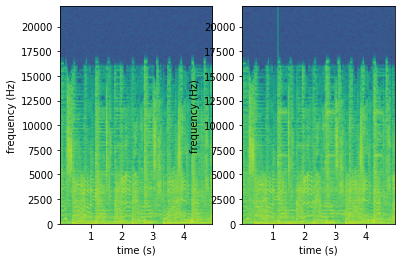

In [58]:
print("The first channel of  spectrogram look like this:")
plt.subplot(121)
plt.specgram(audio[:,0],NFFT=2048,Fs=44100)
plt.xlabel("time (s)")
plt.ylabel("frequency (Hz)")
plt.subplot(122)
plt.specgram(audio[:,1],NFFT=2048,Fs=44100)
plt.xlabel("time (s)")
plt.ylabel("frequency (Hz)")
plt.show()
# print("They look exactly the same, we can study one channel at a time")

In [59]:
audio = torch.Tensor(audio)
audio = audio.permute(1,0).unsqueeze(0)
print("Input audio STFT feature size: ",audio.size())
print("Preparing the data, decompose input signal to "+ str(SUBBANDS_NUM) +" subbands...")
audio_sub = qmf.analysis(audio) # decompose the input signal into four subband in time domain
print("Ok we are done, feature size: ",audio_sub.size())

Input audio STFT feature size:  torch.Size([1, 2, 217360])
Preparing the data, decompose input signal to 4 subbands...
Ok we are done, feature size:  torch.Size([1, 8, 54340])


Visualizing four subband...


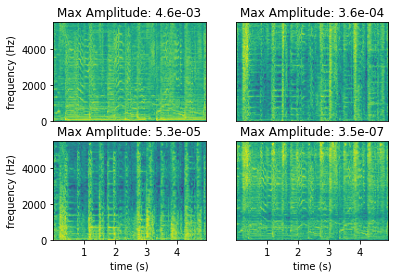

The amplitude of each subband has been normalized by matplotlib, so their energy look alike (actually not, as shown by the title)


In [60]:
print("Visualizing four subband...")

plt.subplot(2,2,1)
spec1,_,_,_ = plt.specgram(audio_sub[0,0,:].numpy(),NFFT=512,Fs=11025)
# plt.title("Normalized by "+str(round(np.max(spec1),7)))
plt.xticks([])
plt.ylabel("frequency (Hz)")
plt.title("Max Amplitude: "+"%.1e"%np.max(spec1))

plt.subplot(2,2,2)

# plt.ylabel("frequency (Hz)")
plt.yticks([])
plt.xticks([])
spec1,_,_,_ = plt.specgram(audio_sub[0,1,:].numpy(),NFFT=512,Fs=11025)
plt.title("Max Amplitude: "+"%.1e"%np.max(spec1))
plt.subplot(2,2,3)

plt.xlabel("time (s)")
plt.ylabel("frequency (Hz)")
spec1,_,_,_ = plt.specgram(audio_sub[0,2,:].numpy(),NFFT=512,Fs=11025)
plt.title("Max Amplitude: "+"%.1e"%np.max(spec1))
plt.subplot(2,2,4)

plt.xlabel("time (s)")
# plt.ylabel("frequency (Hz)")
plt.yticks([])
spec1,_,_,_ = plt.specgram(audio_sub[0,3,:].numpy(),NFFT=512,Fs=11025)
plt.title("Max Amplitude: "+"%.1e"%np.max(spec1))
plt.show()

print("The amplitude of each subband has been normalized by matplotlib, so their energy look alike (actually not, as shown by the title)")
import IPython.display as ipd
ipd.Audio(audio_sub[0,0,:]*32768,rate=11025)

In [61]:
print("Now we start to reconstruct the audio!")
reconstruct_audio = qmf.synthesis(audio_sub) # Synthesis the subband signal
print("Ok we are done, reconstructed audio size: ",reconstruct_audio.size())


Now we start to reconstruct the audio!
Ok we are done, reconstructed audio size:  torch.Size([1, 2, 217360])


Now we have decomposed and reconstructed the signal in time domain. But that's not enough. Usually we like to work on frequency domain. So bellow are the demo of two function that helps you to get the subband frequency feature and do reconstruction painlessly.

In [62]:
print("==================================")

audio = read_wave(fname="song.wav",portion_start=0.2,portion_end=0.22)
audio = torch.Tensor(audio).permute(1,0).unsqueeze(0)
print("Input audio STFT feature size: ",audio.size())

Input audio STFT feature size:  torch.Size([1, 2, 217360])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:327: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [63]:
print("Preparing the data, decompose input signal to "+ str(SUBBANDS_NUM) +" subbands...")
# decompose audio, then transfer each subband to frequency domain
data = before_forward(audio,qmf=qmf,subband_num = SUBBANDS_NUM,sample_rate = 44100) 
print("Ok we are done, feature size: ",data.size())

Preparing the data, decompose input signal to 4 subbands...
Ok we are done, feature size:  torch.Size([1, 16, 257, 618])


In [50]:
# Do some thing with 'data', and then output a tensor with same size with 'data' for reconstruction

In [64]:
print("Now we start to reconstruct the audio!")
# reconstruct audio with frequency subband feature
reconstruct_audio = after_forward(data,qmf=qmf,sample_rate = 44100)
print("Ok we are done, reconstructed audio size: ",reconstruct_audio.size())

Now we start to reconstruct the audio!
Ok we are done, reconstructed audio size:  torch.Size([1, 2, 217184])


In [65]:
print("Let's find out if we have successfully rebuild the audio")
print("Firstly we need to clip away a little bit from 'audio'")
min_length = min(reconstruct_audio.size()[2],audio.size()[2])
reconstruct_audio,audio = reconstruct_audio[...,:min_length],audio[...,:min_length]
print(reconstruct_audio.size(),audio.size())
print("Now they have the same size!")

Let's find out if we have successfully rebuild the audio
Firstly we need to clip away a little bit from 'audio'
torch.Size([1, 2, 217184]) torch.Size([1, 2, 217184])
Now they have the same size!


They just look the same (I only take the first channel for visualization)


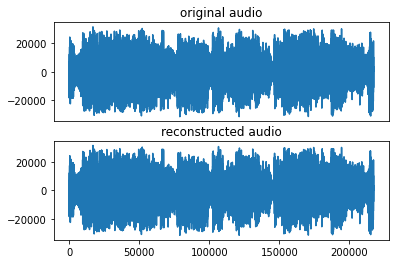

In [66]:
print("They just look the same (I only take the first channel for visualization)")
plt.subplot(212)
plt.title("reconstructed audio")
plt.plot(reconstruct_audio[0,0,:])
plt.subplot(211)
plt.title("original audio")
plt.plot(audio[0,0,:])
plt.xticks([])
plt.show()

In [67]:
print("Let's calculate the MAE between this two audio")
diff = torch.nn.L1Loss()
delta = reconstruct_audio-audio  
print("Relative error:",torch.sum(torch.abs(delta))/torch.sum(torch.abs(audio)))
print("Absolute error:",diff(reconstruct_audio,audio))
print("Exactly the same")

Let's calculate the MAE between this two audio
Relative error: tensor(8.9026e-05)
Absolute error: tensor(0.6008)
Exactly the same


In [68]:
SUBBANDS_NUM = 8
print("First we read some audio data")
# This is the class we use to do subband decomposition(analysis) and reconstruction(synthesis)
qmf = PQMF(SUBBANDS_NUM,64,filters_dir="./filters")
# Let's read a small segment of audio
audio = read_wave(fname="song.wav",portion_start=0.2,portion_end=0.22)
audio = torch.Tensor(audio).permute(1,0).unsqueeze(0)
print(audio.size())
data = before_forward(audio,qmf=qmf,subband_num = SUBBANDS_NUM,sample_rate = 44100)
reconstruct_audio = after_forward(data,qmf=qmf,subband_num = SUBBANDS_NUM,sample_rate = 44100)
diff = torch.nn.L1Loss()
minlen = min(audio.size()[-1],reconstruct_audio.size()[-1])
reconstruct_audio,audio  = reconstruct_audio[...,:minlen],audio[...,:minlen]  
delta = reconstruct_audio-audio  
print("Relative error:",torch.sum(torch.abs(delta))/torch.sum(torch.abs(audio)))
print("Absolute error:",diff(reconstruct_audio,audio))
print("Exactly the same")

First we read some audio data
torch.Size([1, 2, 217360])
Relative error: tensor(0.0004)
Absolute error: tensor(2.5994)
Exactly the same


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:327: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [69]:
SUBBANDS_NUM = 2
print("First we read some audio data")
# This is the class we use to do subband decomposition(analysis) and reconstruction(synthesis)
qmf = PQMF(SUBBANDS_NUM,64,filters_dir="./filters")
# Let's read a small segment of audio
audio = read_wave(fname="song.wav",portion_start=0.2,portion_end=0.22)
audio = torch.Tensor(audio).permute(1,0).unsqueeze(0)
print(audio.size())
data = before_forward(audio,qmf=qmf,subband_num = SUBBANDS_NUM,sample_rate = 44100)
reconstruct_audio = after_forward(data,qmf=qmf,subband_num = SUBBANDS_NUM,sample_rate = 44100)
diff = torch.nn.L1Loss()
minlen = min(audio.size()[-1],reconstruct_audio.size()[-1])
reconstruct_audio,audio  = reconstruct_audio[...,:minlen],audio[...,:minlen]  
delta = reconstruct_audio-audio  
print("Relative error:",torch.sum(torch.abs(delta))/torch.sum(torch.abs(audio)))
print("Absolute error:",diff(reconstruct_audio,audio))
print("Exactly the same")

First we read some audio data
torch.Size([1, 2, 217360])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:327: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Relative error: tensor(8.8687e-05)
Absolute error: tensor(0.5985)
Exactly the same
